In [21]:
import sys 
if '..' not in sys.path:
    sys.path.append('../')
from utils import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

data_path = 'C:\\Users\\Simon Andersen\\Documents\\Uni\\KS6\\AppliedML\\Project 2\\train_dataset_1\\a000_1\\data.hdf5'

data_dict = load_data(data_path, verbose=True)

start=0
stop=60_000

ori =data_dict['pose/tango_ori'][start:stop]  
w = data_dict['synced/gyro'][start:stop]
a = data_dict['synced/acce'][start:stop]
m = data_dict['synced/magnet'][start:stop]

CONTENTS OF HDF5 FILE:
pose
	 ekf_ori, tango_ori, tango_pos
raw
	 imu
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, wifi_address, wifi_values
	 tango
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, tango_adf_pose, tango_pose, wifi_address, wifi_values
synced
	 acce, game_rv, grav, gyro, gyro_uncalib, linacce, magnet, rv, time


In [22]:
## SET PARAMETERS 
w = data_dict['synced/gyro']
Ntot = w.shape[0]

print("Total no. of data points: ", Ntot)
# Set the number of points used to train network
N = 20_000
# set the no. of points used to valiate on
Nval = 1000
assert(N + Nval < Ntot)

n_seen = N

# Set whether to include acceleration and magnetic data when training 
include_acc = True
include_mag = False

# Set no. of layers in model
Nlayers = 30
# Set neurons per layer in model
hidden_size = 128
# Set learning rate
learning_rate = 0.0001
# Set loss function
criterion = nn.L1Loss()
# set n_epochs
num_epochs = 600
# Set how many observations to combine into one datapoint
group_num = 30 # EFFECT: By grouping, we are only giving the model 1 true orientation for every group_num measurements.

Total no. of data points:  67610


In [23]:
# Predict angles analytically
q_gt = data_dict['pose/tango_ori'][N:N + Nval]
dt = data_dict['synced/time'][N+1] - data_dict['synced/time'][N]

q_pred_ana = np.zeros((Nval,4))
q_pred_ana[0] = q_gt[0]
factor= .0025                                # has been set arbitrarily
for i in range(1,Nval):
    q_pred_ana[i] = Theta(w[N + i]*factor, dt=dt)@q_pred_ana[i-1]



In [24]:
# plot
def plot_quat(q_gts, q_preds, xs, names = ['analytical', 'NN']):
    if type(q_preds) is not list:
        q_preds = [q_preds]
    if type(q_gts) is not list:
        q_gts = [q_gts]
    if type(xs) is not list:
        xs = [xs]
    
    fig, ax = plt.subplots(len(q_preds), 4, figsize=(12, 4*len(q_preds)))
    ax = ax.reshape(-1, 4)
    idx = 0
    for q_pred, q_gt,x, name in zip(q_preds, q_gts,xs, names):
        print('q_pred', q_pred.shape, 'q_gt', q_gt.shape, 'x', x.shape)
        ax[idx, 0].plot(x, q_gt[:,0],)
        ax[idx, 0].plot(x, q_pred[:,0],)
        ax[idx, 1].plot(x, q_gt[:,1],)
        ax[idx, 1].plot(x, q_pred[:,1],)
        ax[idx, 2].plot(x, q_gt[:,2],)
        ax[idx, 2].plot(x, q_pred[:,2],)
        ax[idx, 3].plot(x, q_gt[:,3],label='gt')
        ax[idx, 3].plot(x, q_pred[:,3],label=f'pred')
        
        ax[idx, 0].set_title(name)
        idx += 1
    ax[0, 3].legend()
    fig.suptitle('Quaternion Update test')
    plt.tight_layout()

#plot_quat(q_gt, q_pred_ana, np.arange(N, N + Nval))

## NN

In [25]:
def get_data(start=0, stop=1500, group_num=40, include_mag = False, include_acc = False):

    ori =data_dict['pose/tango_ori'][start:stop]  
    w = data_dict['synced/gyro'][start:stop]
    a = data_dict['synced/acce'][start:stop]
    m = data_dict['synced/magnet'][start:stop]
    #print shapes
    print('ori.shape', ori.shape, 'w.shape', w.shape, 'a.shape', a.shape, 'm.shape', m.shape)

    # Now we group all N datapoints into N/group_num rows. To do this, we discard rows to 
    # ensure that N is divisble by group_num_rows
    w = w[:-(w.shape[0]%group_num)] if w.shape[0]%group_num != 0 else w
    a = a[:-(a.shape[0]%group_num)] if a.shape[0]%group_num != 0 else a
    m = m[:-(m.shape[0]%group_num)] if m.shape[0]%group_num != 0 else m
    ori = ori[:-(ori.shape[0]%group_num)] if ori.shape[0]%group_num != 0 else ori

    # reshape
    w_10 = w.reshape(-1,group_num*w.shape[1])
    a_10 = a.reshape(-1,group_num*a.shape[1])
    m_10 = m.reshape(-1,group_num*m.shape[1])
    ori_10 = ori.reshape(-1,group_num*ori.shape[1])
    
    print('w_10.shape', w_10.shape)
    print('m_10.shape', m_10.shape)
    print('a_10.shape ', a_10.shape)
    print('ori_10.shape', ori_10.shape)

    if include_mag and include_acc:
        X = np.hstack([w_10, a_10, m_10, ori_10[:,:4] ])
    elif include_mag:
        X = np.hstack([w_10, m_10, ori_10[:,:4] ])
    elif include_acc:
        X = np.hstack([w_10, a_10, ori_10[:,:4] ])
    else:
        X = np.hstack([w_10, ori_10[:,:4] ])

    y = ori_10[:,-4:]  

    print(X.shape, y.shape)

    return X, y


X, y = get_data(start=0, stop=n_seen, group_num=group_num, include_acc=include_acc, include_mag=include_mag)



ori.shape (20000, 4) w.shape (20000, 3) a.shape (20000, 3) m.shape (20000, 3)
w_10.shape (666, 90)
m_10.shape (666, 90)
a_10.shape  (666, 90)
ori_10.shape (666, 120)
(666, 184) (666, 4)


In [26]:
# set up a neural network with 3 inputs and 16 outputs
# the 3 inputs are the 3 components of the angular velocity
# the 16 outputs are the 16 elements of the 4x4 matrix Theta(w)


class Net(nn.Module):
    def __init__(self, input_size=13, output_size=16, hidden_size=16, num_layers=2):
        super(Net, self).__init__()
        self.num_layers = num_layers
        self.fc_input = nn.Linear(input_size, hidden_size)
        hidden_layers = []
        for i in range(self.num_layers):
            hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.hidden_layers = nn.ModuleList(hidden_layers)

        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #print(x)
        x = F.relu(self.fc_input(x))
        for i in range(self.num_layers):
            x = F.relu(self.hidden_layers[i](x))
            
        x = self.fc_output(x)
        return x

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


net = Net(input_size=X.shape[1], output_size=4, hidden_size=hidden_size, num_layers=Nlayers)

# mount model to device
net.to(device)
# number of params
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Using device: cuda
NVIDIA GeForce 940MX
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Number of parameters: 519556


In [27]:
# data preparation


# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=False)

# convert to torch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# dataset
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)






In [28]:
import time

# optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)


t_start = time.time()
for epoch in range(num_epochs):
    running_loss = 0.0
    n_minibatches = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        n_minibatches += 1
    print('Epoch %d, loss: %.5f' % (epoch+1, running_loss/n_minibatches))

    # test
    with torch.no_grad():
        running_loss = 0.0
        n_minibatches = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            n_minibatches += 1
        print('Test loss: %.5f' % (running_loss/n_minibatches))

t_end = time.time()
print("Training time: ", t_end - t_start)

Epoch 1, loss: 0.44458
Test loss: 0.41824
Epoch 2, loss: 0.44360
Test loss: 0.41315
Epoch 3, loss: 0.43879
Test loss: 0.40808
Epoch 4, loss: 0.43381
Test loss: 0.40293
Epoch 5, loss: 0.43003
Test loss: 0.39779
Epoch 6, loss: 0.42443
Test loss: 0.39259
Epoch 7, loss: 0.42206
Test loss: 0.38736
Epoch 8, loss: 0.41714
Test loss: 0.38214
Epoch 9, loss: 0.41245
Test loss: 0.37669
Epoch 10, loss: 0.41152
Test loss: 0.37078
Epoch 11, loss: 0.40831
Test loss: 0.36445
Epoch 12, loss: 0.40275
Test loss: 0.35766
Epoch 13, loss: 0.39675
Test loss: 0.35063
Epoch 14, loss: 0.38990
Test loss: 0.34275
Epoch 15, loss: 0.38300
Test loss: 0.33367
Epoch 16, loss: 0.37234
Test loss: 0.32263
Epoch 17, loss: 0.36184
Test loss: 0.30940
Epoch 18, loss: 0.34582
Test loss: 0.29139
Epoch 19, loss: 0.33556
Test loss: 0.26866
Epoch 20, loss: 0.31215
Test loss: 0.24573
Epoch 21, loss: 0.31103
Test loss: 0.23831
Epoch 22, loss: 0.30645
Test loss: 0.24092
Epoch 23, loss: 0.30452
Test loss: 0.24863
Epoch 24, loss: 0.30

ori.shape (1000, 4) w.shape (1000, 3) a.shape (1000, 3) m.shape (1000, 3)
w_10.shape (33, 90)
m_10.shape (33, 90)
a_10.shape  (33, 90)
ori_10.shape (33, 120)
(33, 184) (33, 4)
q_pred (1000, 4) q_gt (1000, 4) x (1000,)
q_pred (33, 4) q_gt (33, 4) x (33,)


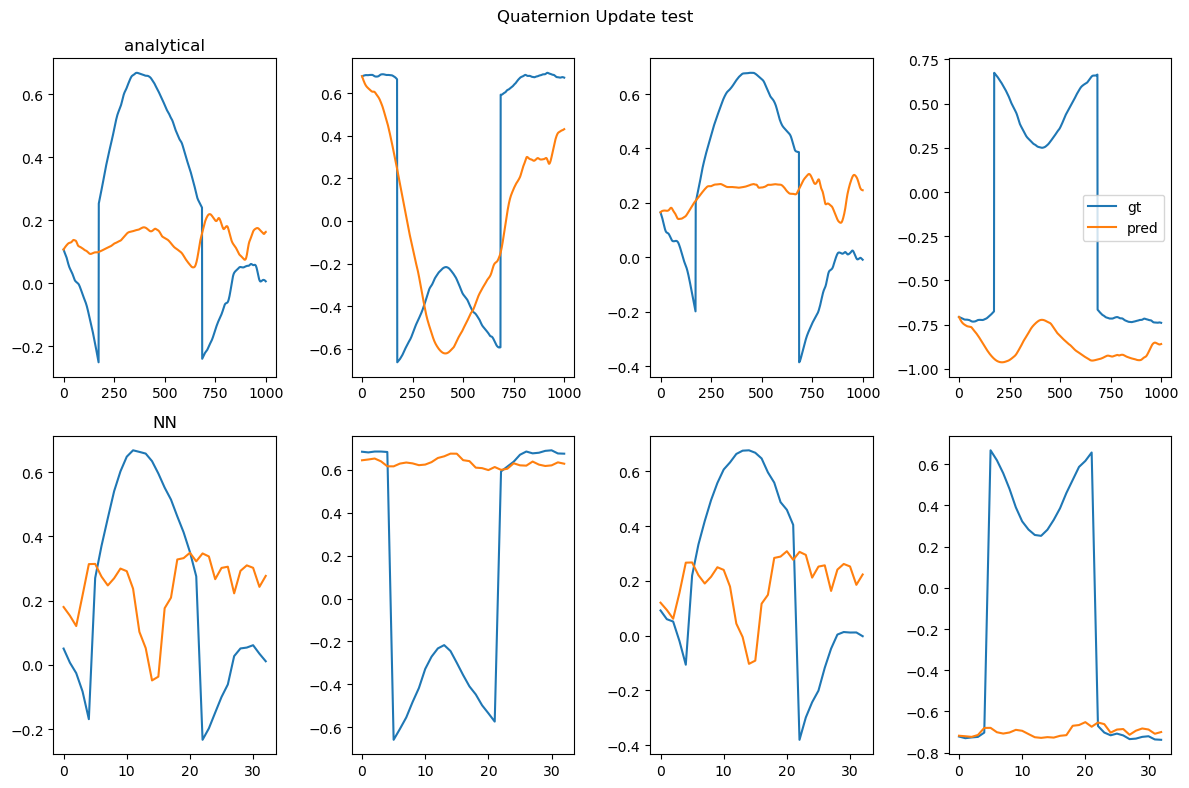

In [29]:
# testing unseen         

n_unseen = Nval

start, end = n_seen, n_seen+n_unseen
#start, end = 0, n_unseen


X_unseen, y_unseen = get_data(start=start, stop=end, group_num = group_num, include_acc=include_acc, include_mag=include_mag)


y_pred = []
if 1:
    with torch.no_grad():
        for i in range(len(X_unseen)):
            if i > 0:
                X_unseen[i, -4:] = y_pred[i-1]

            inputs = torch.from_numpy(X_unseen[i]).float()
            # mount to gpu if using
            inputs = inputs.to(device)
            outputs = net(inputs)
            # copy to cpu and store prediction
            outputs_cpu = torch.Tensor.cpu(outputs)
            y_pred.append(outputs_cpu.numpy())


y_pred = np.array(y_pred)
q_gts = [q_gt, y_unseen]
q_preds = [q_pred_ana, y_pred]
xs = [np.arange(len(q_gt)), np.arange(len(y_unseen))]
plot_quat(q_gts, q_preds, xs, names = ['analytical', 'NN'])
plt.savefig('../assets/quat_nn.png')


In [30]:
lstm = torch.load('load/from/path/model.pt')

FileNotFoundError: [Errno 2] No such file or directory: 'load/from/path/model.pt'